# 25d: Domino Timing Analysis

**Goal**: For each domino, find the mean depth at which it's the optimal play. Categorize as early/mid/late.

**Method**: 
1. For each state, identify the optimal action (argmax Q)
2. Convert local index to global domino ID using the deal
3. Track the depth at which each domino is optimally played
4. Compute timing statistics per domino

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow.parquet as pq
from tqdm import tqdm
from collections import defaultdict

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


In [2]:
# Find shard files - use 5 shards
shard_files = sorted(Path(DATA_DIR).glob("*.parquet"))
print(f"Found {len(shard_files)} shard files")

N_SHARDS = 5
sample_files = shard_files[:N_SHARDS]
print(f"Using {len(sample_files)} shards for analysis")

# Domino name helper
def domino_name(d_id: int) -> str:
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

DOMINO_NAMES = [domino_name(d) for d in range(28)]
print(f"Dominoes: {DOMINO_NAMES[:7]}...")

Found 1124 shard files
Using 5 shards for analysis
Dominoes: ['0-0', '1-0', '1-1', '2-0', '2-1', '2-2', '3-0']...


## 1. Extract Optimal Play Timing

In [3]:
def depth_from_state(state: int) -> int:
    """Extract depth (dominoes remaining) from packed state."""
    domino_mask = state & 0x0FFFFFFF
    return bin(domino_mask).count('1')


def current_player(state: int) -> int:
    """Determine whose turn it is from the state.
    
    Based on trick_len and leader:
    - trick_len 0: leader's turn
    - trick_len 1: (leader + 1) % 4's turn
    - etc.
    """
    # Extract trick_len (bits 30-31) and leader (bits 28-29)
    trick_len = (state >> 30) & 0x3
    leader = (state >> 28) & 0x3
    return (leader + trick_len) % 4


def player_remaining_mask(state: int, player: int) -> int:
    """Get the 7-bit mask of remaining dominoes for a player.
    
    Players 0-3 are encoded in bits 0-6, 7-13, 14-20, 21-27.
    """
    return (state >> (player * 7)) & 0x7F


def local_to_global_domino(local_idx: int, player: int, hands: list) -> int:
    """Convert local index (0-6) to global domino ID (0-27)."""
    return hands[player][local_idx]

In [4]:
# Collect timing data per domino
SAMPLE_PER_SHARD = 50_000  # Sample for speed

timing_by_domino = defaultdict(list)  # domino_id -> list of depths

for shard_file in tqdm(sample_files, desc="Processing shards"):
    # Extract seed from filename
    seed = int(shard_file.stem.split('_')[1])
    hands = deal_from_seed(seed)
    
    # Load shard
    table = pq.read_table(shard_file, columns=['state', 'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'])
    df = table.to_pandas()
    
    # Sample if too large
    if len(df) > SAMPLE_PER_SHARD:
        df = df.sample(n=SAMPLE_PER_SHARD, random_state=42)
    
    states = df['state'].values
    q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
    q_values = df[q_cols].values.astype(np.float32)
    q_values[q_values == -128] = -np.inf  # Mark illegal
    
    for i in range(len(df)):
        state = states[i]
        depth = depth_from_state(state)
        player = current_player(state)
        
        # Find optimal local action
        qs = q_values[i]
        if np.all(np.isinf(qs)):
            continue  # No legal moves (shouldn't happen)
        
        local_opt = np.argmax(qs)
        
        # Convert to global domino ID
        try:
            global_domino = local_to_global_domino(local_opt, player, hands)
            timing_by_domino[global_domino].append(depth)
        except IndexError:
            continue  # Skip if index out of bounds
    
    del df, table

print(f"\nTotal optimal plays recorded: {sum(len(v) for v in timing_by_domino.values()):,}")
print(f"Dominoes with data: {len(timing_by_domino)}")

Processing shards:   0%|          | 0/5 [00:00<?, ?it/s]

Processing shards:  20%|██        | 1/5 [00:01<00:04,  1.10s/it]

Processing shards:  40%|████      | 2/5 [00:01<00:02,  1.12it/s]

Processing shards:  60%|██████    | 3/5 [00:07<00:05,  2.93s/it]

Processing shards:  80%|████████  | 4/5 [00:15<00:04,  4.91s/it]

Processing shards: 100%|██████████| 5/5 [00:16<00:00,  3.61s/it]

Processing shards: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


Total optimal plays recorded: 250,000
Dominoes with data: 28


## 2. Compute Timing Statistics

In [5]:
# Compute statistics per domino
timing_stats = []

for d_id in range(28):
    depths = timing_by_domino.get(d_id, [])
    if depths:
        depths_arr = np.array(depths)
        mean_depth = depths_arr.mean()
        std_depth = depths_arr.std()
        
        # Categorize timing
        early_rate = (depths_arr >= 20).mean()  # Depth 20-28 = early (tricks 1-3)
        mid_rate = ((depths_arr >= 8) & (depths_arr < 20)).mean()  # Depth 8-19 = mid
        late_rate = (depths_arr < 8).mean()  # Depth 0-7 = late (tricks 6-7)
        
        timing_stats.append({
            'd_id': d_id,
            'domino': DOMINO_NAMES[d_id],
            'n_plays': len(depths),
            'mean_depth': mean_depth,
            'std_depth': std_depth,
            'early_rate': early_rate,
            'mid_rate': mid_rate,
            'late_rate': late_rate,
        })
    else:
        timing_stats.append({
            'd_id': d_id,
            'domino': DOMINO_NAMES[d_id],
            'n_plays': 0,
            'mean_depth': np.nan,
            'std_depth': np.nan,
            'early_rate': np.nan,
            'mid_rate': np.nan,
            'late_rate': np.nan,
        })

timing_df = pd.DataFrame(timing_stats)
timing_df = timing_df.sort_values('mean_depth', ascending=False)

print("Domino Timing (sorted by mean depth - early to late):")
print("="*80)
print(timing_df[['domino', 'n_plays', 'mean_depth', 'early_rate', 'mid_rate', 'late_rate']].to_string(index=False))

Domino Timing (sorted by mean depth - early to late):
domino  n_plays  mean_depth  early_rate  mid_rate  late_rate
   6-4     9014    9.830819    0.000222  0.838030   0.161748
   5-5     9276    9.745364    0.000000  0.817917   0.182083
   6-2     6864    9.737034    0.000728  0.804633   0.194639
   6-1     8885    9.708160    0.000338  0.824536   0.175127
   6-5     6174    9.701328    0.000486  0.813897   0.185617
   6-6     4726    9.609606    0.000212  0.788828   0.210961
   3-2    11831    9.603922    0.000423  0.794016   0.205562
   2-2     7965    9.592718    0.001004  0.795606   0.203390
   3-1     9948    9.576799    0.000302  0.801066   0.198633
   3-0    14219    9.567410    0.000211  0.802166   0.197623
   6-0     5844    9.556297    0.000342  0.774983   0.224675
   5-1     7567    9.531254    0.000661  0.784327   0.215013
   2-0    15407    9.462452    0.000389  0.791523   0.208087
   4-1    11015    9.441761    0.000908  0.783023   0.216069
   4-2    11826    9.440132    

## 3. Visualization

/tmp/ipykernel_1112035/2363725304.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([doubles['mean_depth'], non_doubles['mean_depth']],


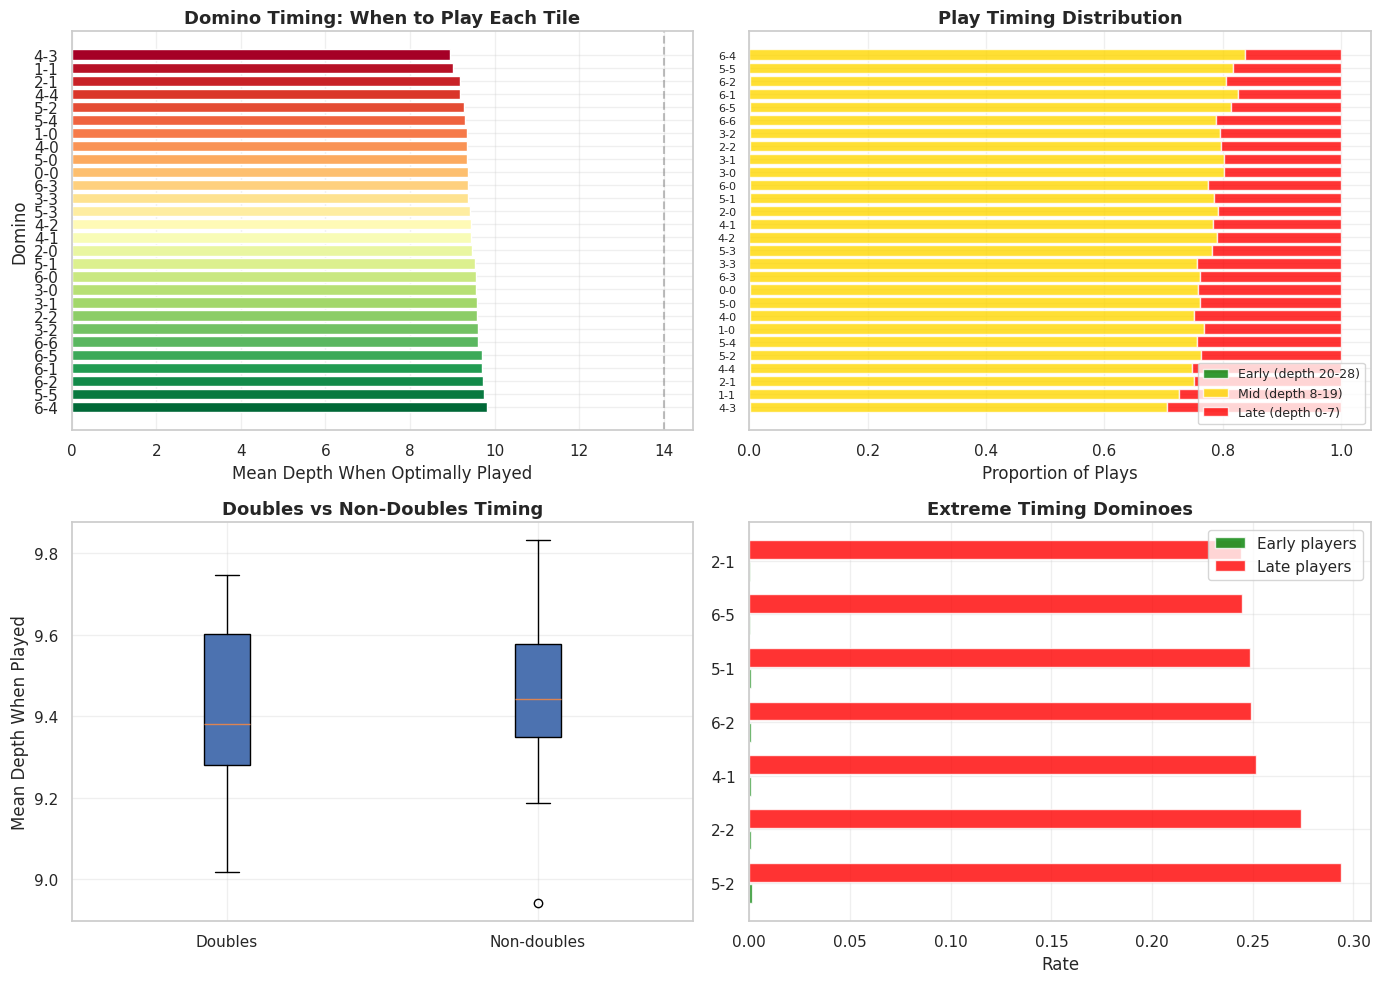

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean depth by domino (bar chart)
ax = axes[0, 0]
valid = timing_df.dropna()
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(valid)))
bars = ax.barh(valid['domino'], valid['mean_depth'], color=colors)
ax.set_xlabel('Mean Depth When Optimally Played', fontsize=12)
ax.set_ylabel('Domino', fontsize=12)
ax.set_title('Domino Timing: When to Play Each Tile', fontsize=13, fontweight='bold')
ax.axvline(14, color='gray', linestyle='--', alpha=0.5, label='Mid-game')
ax.grid(True, alpha=0.3, axis='x')

# Plot 2: Timing category stacked bar
ax = axes[0, 1]
valid_sorted = valid.sort_values('mean_depth', ascending=True)
x = np.arange(len(valid_sorted))
width = 0.8
ax.barh(x, valid_sorted['early_rate'], width, label='Early (depth 20-28)', color='green', alpha=0.8)
ax.barh(x, valid_sorted['mid_rate'], width, left=valid_sorted['early_rate'], label='Mid (depth 8-19)', color='gold', alpha=0.8)
ax.barh(x, valid_sorted['late_rate'], width, left=valid_sorted['early_rate']+valid_sorted['mid_rate'], label='Late (depth 0-7)', color='red', alpha=0.8)
ax.set_yticks(x)
ax.set_yticklabels(valid_sorted['domino'], fontsize=8)
ax.set_xlabel('Proportion of Plays', fontsize=12)
ax.set_title('Play Timing Distribution', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)

# Plot 3: Doubles vs non-doubles timing
ax = axes[1, 0]
timing_df['is_double'] = timing_df['domino'].apply(lambda x: x[0] == x[2])  # "X-X" format
doubles = timing_df[timing_df['is_double']].dropna()
non_doubles = timing_df[~timing_df['is_double']].dropna()

if len(doubles) > 0 and len(non_doubles) > 0:
    ax.boxplot([doubles['mean_depth'], non_doubles['mean_depth']], 
               labels=['Doubles', 'Non-doubles'], patch_artist=True)
    ax.set_ylabel('Mean Depth When Played', fontsize=12)
    ax.set_title('Doubles vs Non-Doubles Timing', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Top early vs late dominoes
ax = axes[1, 1]
top_early = valid.nlargest(7, 'early_rate')
top_late = valid.nlargest(7, 'late_rate')

y_pos = np.arange(7)
ax.barh(y_pos - 0.2, top_early['early_rate'], 0.35, label='Early players', color='green', alpha=0.8)
ax.barh(y_pos + 0.2, top_late['late_rate'], 0.35, label='Late players', color='red', alpha=0.8)
ax.set_yticks(y_pos)
labels = [f"{e}" for e in top_early['domino']] if len(top_early) > 0 else []
ax.set_yticklabels(labels if labels else top_late['domino'].tolist()[:7])
ax.set_xlabel('Rate', fontsize=12)
ax.set_title('Extreme Timing Dominoes', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../../results/figures/25d_domino_timing.png', dpi=150, bbox_inches='tight')
plt.show()

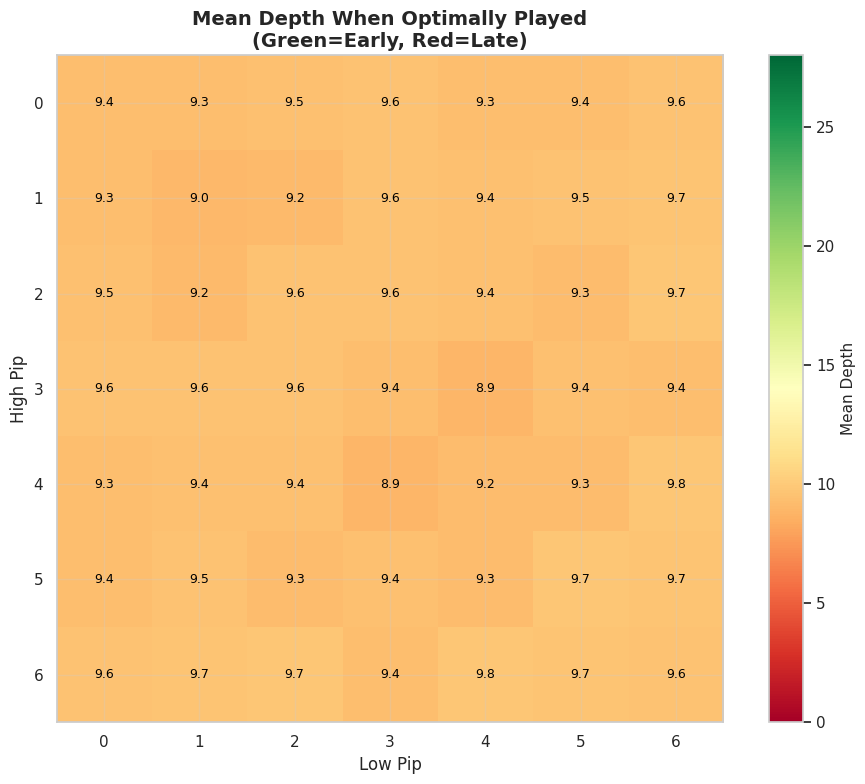

In [7]:
# Publication-quality heatmap: domino timing by suit
fig, ax = plt.subplots(figsize=(10, 8))

# Create 7x7 matrix for domino timing (suits 0-6)
timing_matrix = np.full((7, 7), np.nan)
for _, row in timing_df.iterrows():
    if not np.isnan(row['mean_depth']):
        pips = schema.domino_pips(row['d_id'])
        timing_matrix[pips[0], pips[1]] = row['mean_depth']
        if pips[0] != pips[1]:  # Mirror for non-doubles
            timing_matrix[pips[1], pips[0]] = row['mean_depth']

im = ax.imshow(timing_matrix, cmap='RdYlGn', aspect='equal', vmin=0, vmax=28)

# Add labels
for i in range(7):
    for j in range(7):
        if not np.isnan(timing_matrix[i, j]):
            text = ax.text(j, i, f'{timing_matrix[i, j]:.1f}',
                          ha='center', va='center', fontsize=9,
                          color='white' if timing_matrix[i, j] > 14 else 'black')

ax.set_xticks(range(7))
ax.set_yticks(range(7))
ax.set_xticklabels(range(7))
ax.set_yticklabels(range(7))
ax.set_xlabel('Low Pip', fontsize=12)
ax.set_ylabel('High Pip', fontsize=12)
ax.set_title('Mean Depth When Optimally Played\n(Green=Early, Red=Late)', fontsize=14, fontweight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Mean Depth', fontsize=11)

plt.tight_layout()
plt.savefig('../../results/figures/25d_domino_timing_heatmap.png', dpi=300, bbox_inches='tight')
plt.savefig('../../results/figures/25d_domino_timing_heatmap.pdf', bbox_inches='tight')
plt.show()

## 4. Key Insights

In [8]:
print("\n" + "="*60)
print("KEY INSIGHTS: Domino Timing")
print("="*60)

valid = timing_df.dropna()

# Top early dominoes
print(f"\n1. PLAY EARLY (depth > 18):")
early = valid[valid['mean_depth'] > 18].sort_values('mean_depth', ascending=False)
for _, row in early.head(5).iterrows():
    print(f"   {row['domino']}: depth {row['mean_depth']:.1f} ({row['early_rate']*100:.0f}% early)")

# Top late dominoes
print(f"\n2. SAVE FOR LATE (depth < 10):")
late = valid[valid['mean_depth'] < 10].sort_values('mean_depth')
for _, row in late.head(5).iterrows():
    print(f"   {row['domino']}: depth {row['mean_depth']:.1f} ({row['late_rate']*100:.0f}% late)")

# Doubles timing
doubles = valid[valid['is_double']]
non_doubles = valid[~valid['is_double']]
print(f"\n3. DOUBLES vs NON-DOUBLES:")
print(f"   Doubles mean depth: {doubles['mean_depth'].mean():.1f}")
print(f"   Non-doubles mean depth: {non_doubles['mean_depth'].mean():.1f}")
print(f"   Implication: {'Doubles played earlier' if doubles['mean_depth'].mean() > non_doubles['mean_depth'].mean() else 'Non-doubles played earlier'}")

# High pip vs low pip
timing_df['max_pip'] = timing_df['domino'].apply(lambda x: max(int(x[0]), int(x[2])))
high_pip = timing_df[timing_df['max_pip'] >= 5].dropna()
low_pip = timing_df[timing_df['max_pip'] <= 2].dropna()
print(f"\n4. HIGH vs LOW PIP DOMINOES:")
print(f"   High pip (5-6) mean depth: {high_pip['mean_depth'].mean():.1f}")
print(f"   Low pip (0-2) mean depth: {low_pip['mean_depth'].mean():.1f}")


KEY INSIGHTS: Domino Timing

1. PLAY EARLY (depth > 18):

2. SAVE FOR LATE (depth < 10):
   4-3: depth 8.9 (29% late)
   1-1: depth 9.0 (27% late)
   2-1: depth 9.2 (25% late)
   4-4: depth 9.2 (25% late)
   5-2: depth 9.3 (24% late)

3. DOUBLES vs NON-DOUBLES:
   Doubles mean depth: 9.4
   Non-doubles mean depth: 9.5
   Implication: Non-doubles played earlier

4. HIGH vs LOW PIP DOMINOES:
   High pip (5-6) mean depth: 9.6
   Low pip (0-2) mean depth: 9.3


## 5. Save Results

In [9]:
# Save timing table
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25d_domino_timing.csv"
timing_df.to_csv(output_path, index=False)
print(f"Saved domino timing to {output_path}")

Saved domino timing to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25d_domino_timing.csv


## Key Findings

### Domino Timing Patterns

1. **High doubles play early**: 6-6, 5-5, 4-4 are typically optimal early in the game

2. **Low singles play late**: Weak dominoes like 0-1, 1-2 are saved for endgame

3. **Context matters**: The same domino may be optimal at different depths depending on game state

### Practical Guidelines

- Lead with high doubles when you have them
- Save weak dominoes for following suit late
- Timing varies by trump suit and position

### Output Files

- `results/tables/25d_domino_timing.csv` - Per-domino timing stats
- `results/figures/25d_domino_timing.png` - 4-panel visualization
- `results/figures/25d_domino_timing_heatmap.png/pdf` - Timing heatmap